In [1]:
def segmentation(img) :
    preprocessing = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #preprocessing = cv2.Canny(preprocessing, 20, 20)
    #preprocessing = cv2.resize(preprocessing, (480,480), interpolation=cv2.INTER_LINEAR)
    #preprocessing = cv2.medianBlur(preprocessing, 11)
    preprocessing = cv2.medianBlur(preprocessing, 5)
    ret, _ = cv2.threshold(preprocessing, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    rows = preprocessing.shape[0]
    circles = cv2.HoughCircles(preprocessing, cv2.HOUGH_GRADIENT, 1, rows / 4, param1=120, param2=10, minRadius=250, maxRadius=300)
    #circles = cv2.HoughCircles(preprocessing, cv2.HOUGH_GRADIENT, 1, rows / 4, param1=ret, param2=10, minRadius=250, maxRadius=480)
    
    if circles is not None :
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            center = (i[0], i[1])
            #cv2.circle(preprocessing, center, 1, (255, 255, 0), 3)
            radius = i[2]
            cv2.circle(preprocessing, center, radius, (255, 0, 255), 3)
    
    return preprocessing, radius

In [2]:
def removeReflection(img):
    ret, mask = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(mask, kernel, iterations=1)
    preprocessing = cv2.inpaint(img, dilation, 5, cv2.INPAINT_TELEA)
    
    return preprocessing

In [3]:
def rubberSheetModel(image, height, width, r_in, r_out, center):
    thetas = np.arange(0, 2 * np.pi, 2 * np.pi / width)  # Theta values
    #r_out = r_in + r_out
    # Create empty flatten image
    flat = np.zeros((height,width, 3), np.uint8)
    #circle_x = int(image.shape[0] / 2)
    #circle_y = int(image.shape[1] / 2)
    circle_x = int(center[0])
    circle_y = int(center[1])
    
    for i in range(width):
        for j in range(height):
            theta = thetas[i]  # value of theta coordinate
            r_pro = j / height  # value of r coordinate(normalized)

            # get coordinate of boundaries
            Xi = circle_x + r_in * np.cos(theta)
            Yi = circle_y + r_in * np.sin(theta)
            
            Xo = circle_x + r_out * np.cos(theta)
            Yo = circle_y + r_out * np.sin(theta)

            # the matched cartesian coordinates for the polar coordinates
            Xc = (1 - r_pro) * Xi + r_pro * Xo
            Yc = (1 - r_pro) * Yi + r_pro * Yo
            
            #if(Xc > width):
                #Xc = width - 1
            
            if Xc >= image.shape[0] :
                Xc = image.shape[0] - 1
                
            #if(Yc > height):
            #    Yc = height - 1
            
            if Yc >= image.shape[1] :
                Yc = image.shape[1] - 1
            
            color = image[int(Xc)][int(Yc)]  # color of the pixel

            flat[j][i] = color
    
    return flat

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.cluster import KMeans
from scipy import stats

def houghTransform(img) :
    #Hough Transform to detect the iris
    input_img = img.copy()
    real_img = input_img.copy()
    preprocessing = cv2.cvtColor(real_img, cv2.COLOR_BGR2GRAY)
    preprocessing = cv2.medianBlur(preprocessing, 7)
    ret, line = cv2.threshold(preprocessing, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    preprocessing = cv2.Canny(preprocessing, 20, 30, apertureSize=3)
    #preprocessing = cv2.Canny(line,0,0)

    rows = preprocessing.shape[0]
    circles = cv2.HoughCircles(preprocessing, cv2.HOUGH_GRADIENT, 1, rows / 4, param1=ret, param2=10, minRadius=250, maxRadius=real_img.shape[0])

    img_center = (int(real_img.shape[0]/2),int(real_img.shape[1] /2))
    img_radius = int(real_img.shape[0])

    x = []
    if circles is not None :
        circles = np.uint16(np.around(circles))
        begin = True
        for i in circles[0, :]:
            center = (i[0], i[1])
            radius = i[2]
            cv2.circle(preprocessing, center, radius, (255, 0, 255), 3)

            x.append(center)
    
    #print(radius)
    #print(len(x))

    z = np.abs(stats.zscore(x))
    x_o = np.array(x)[(z < 1.3).all(axis=1)]
    #print(len(x_o))
    #print(real_img.shape[0]/2)

    clf = KMeans(n_clusters=1, random_state=0).fit(x_o)
    cluster_center = (int(clf.cluster_centers_[0][0]) ,int(clf.cluster_centers_[0][1]))
    
    #radius = int(real_img.shape[0]/2) - 30
    radius = int(real_img.shape[0]/2)
    
    #r_in = int(radius * 0.7)
    r_in = int(radius * 0.8)
    #r_in = 0
    #r_out = radius
    r_out = int(radius * 0.9)
    #h = radius
    h = int(radius * 0.3)
    w = int(radius * 2 * np.pi)
    fin_img = rubberSheetModel(input_img, h, w, r_in, r_out, cluster_center)

    #Preprocess Image
    fin_img = cv2.cvtColor(fin_img, cv2.COLOR_BGR2GRAY)

    # print(pixels)        

    otsu_threshold, image_result = cv2.threshold(fin_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #histr = cv2.calcHist([image_result],[0],None,[256],[0,256])
    histr, bin_edges = np.histogram(image_result, bins=256, range=(0.0, 1.0))

    return otsu_threshold

tinggi : 1.jpg : 136.0


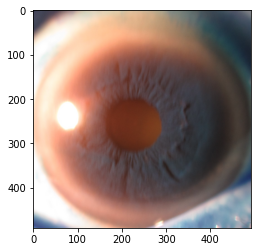

tinggi : 10.jpg : 161.0


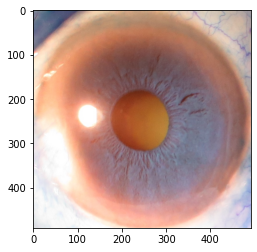

tinggi : 11.jpg : 133.0


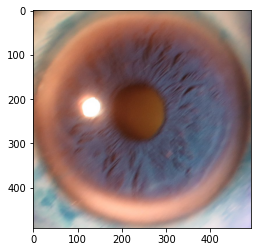

tinggi : 12.jpg : 163.0


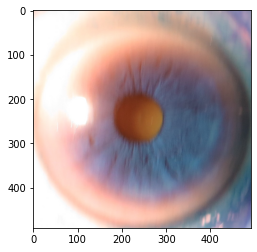

tinggi : 13.jpg : 155.0


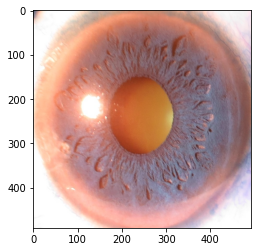

tinggi : 14.jpg : 121.0


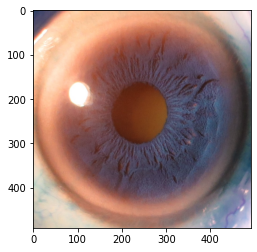

tinggi : 2.jpg : 117.0


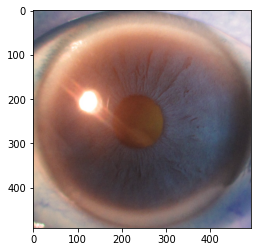

tinggi : 3.jpg : 157.0


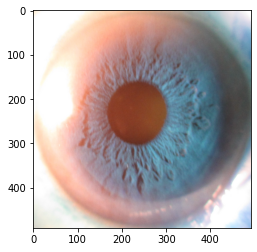

tinggi : 4.jpg : 167.0


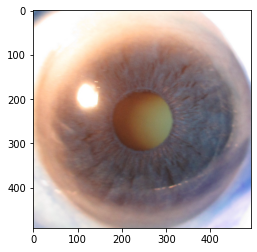

tinggi : 5.jpg : 128.0


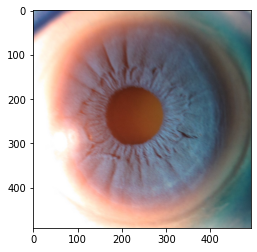

tinggi : 6.jpg : 164.0


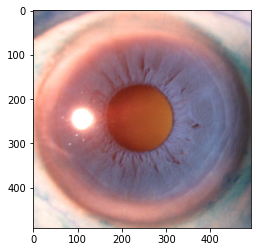

tinggi : 7.jpg : 163.0


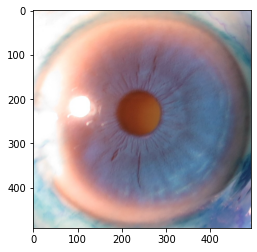

tinggi : 8.jpg : 160.0


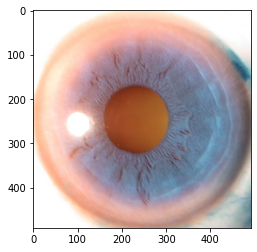

tinggi : 9.jpg : 90.0


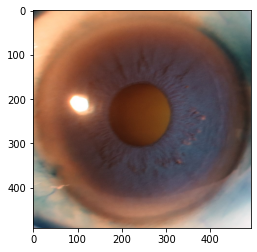

sedang : 1.jpg : 76.0


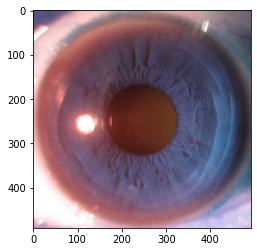

sedang : 10.jpg : 126.0


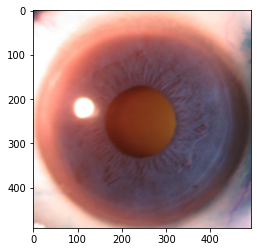

sedang : 11.jpg : 109.0


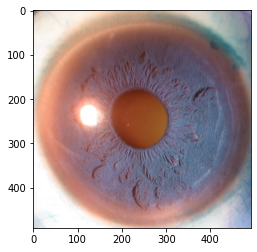

sedang : 12.jpg : 88.0


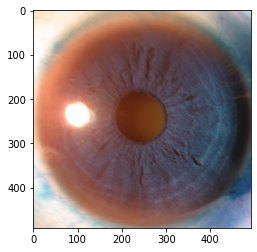

sedang : 13.jpg : 102.0


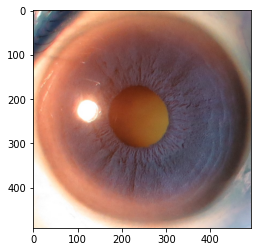

sedang : 14.jpg : 100.0


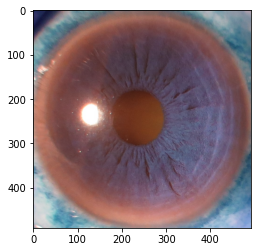

sedang : 15.jpg : 174.0


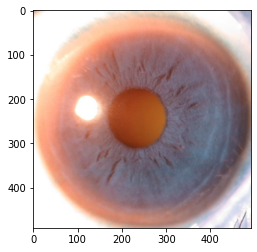

sedang : 16.jpg : 86.0


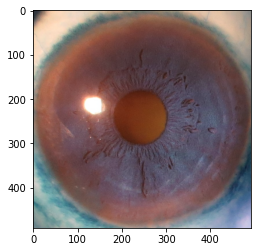

sedang : 17.jpg : 91.0


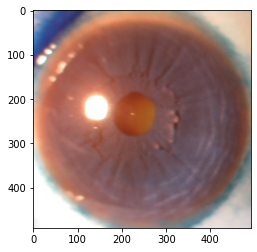

sedang : 18.jpg : 168.0


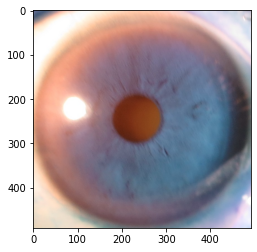

sedang : 19.jpg : 127.0


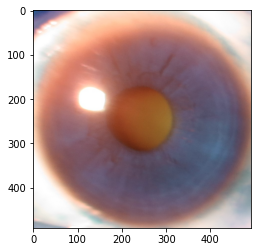

sedang : 2.jpg : 162.0


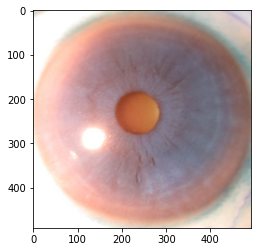

sedang : 20.jpg : 146.0


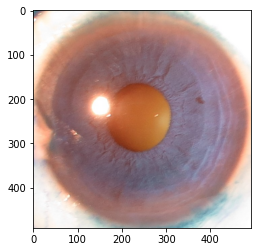

sedang : 22.jpg : 118.0


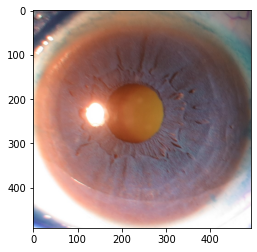

sedang : 23.jpg : 103.0


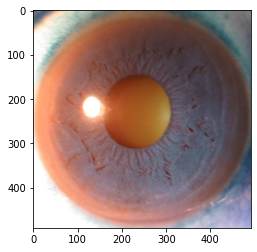

sedang : 24.jpg : 116.0


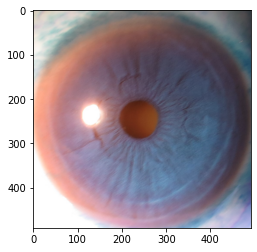

sedang : 25.jpg : 128.0


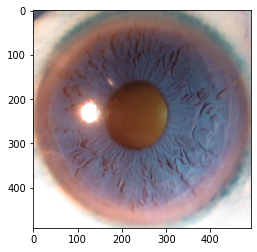

sedang : 26.jpg : 96.0


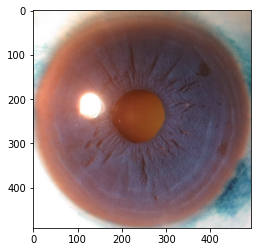

sedang : 27.jpg : 121.0


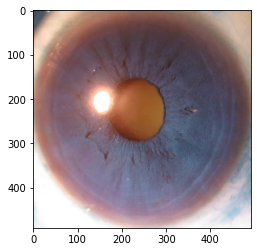

sedang : 28.jpg : 129.0


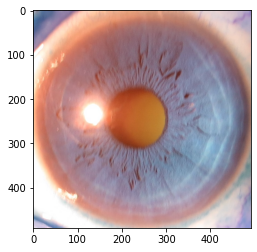

sedang : 29.jpg : 94.0


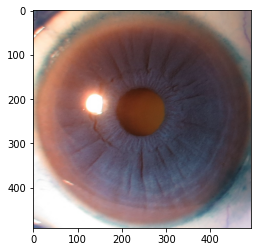

sedang : 3.jpg : 132.0


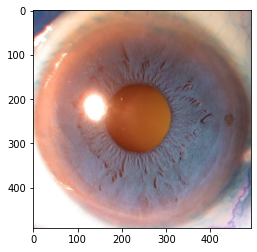

sedang : 4.jpg : 97.0


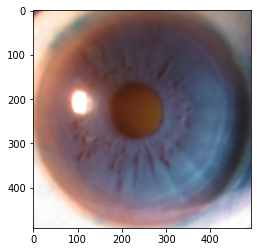

sedang : 5.jpg : 119.0


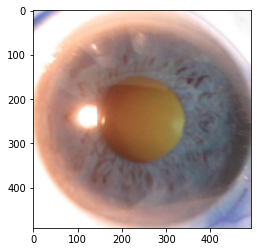

sedang : 6.jpg : 157.0


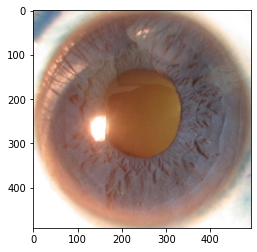

sedang : 7.jpg : 164.0


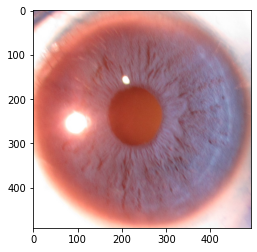

sedang : 8.jpg : 154.0


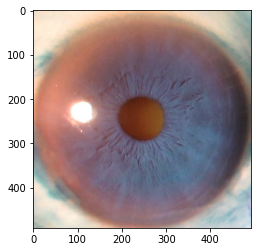

sedang : 9.jpg : 125.0


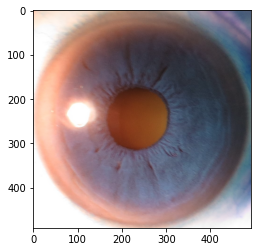

normal : 1.jpg : 158.0


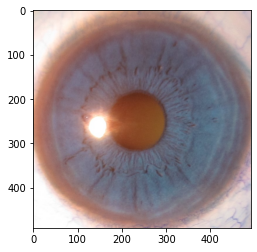

normal : 10.jpg : 114.0


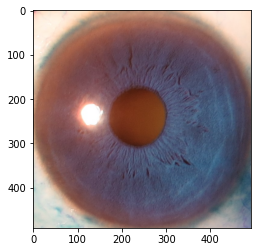

normal : 11.jpg : 93.0


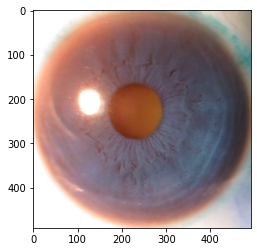

normal : 12.jpg : 105.0


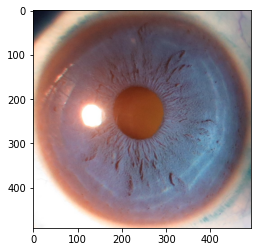

normal : 13.jpg : 99.0


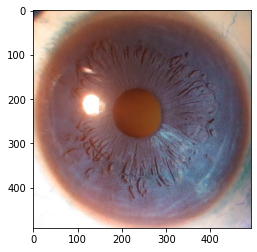

normal : 14.jpg : 150.0


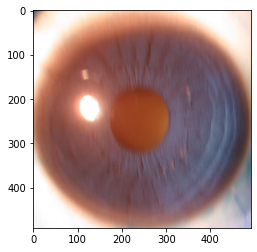

normal : 15.jpg : 171.0


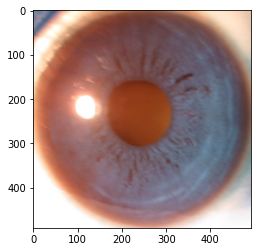

normal : 16.jpg : 155.0


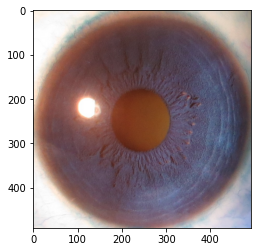

normal : 17.jpg : 73.0


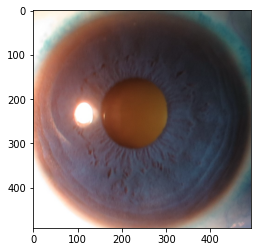

normal : 18.jpg : 93.0


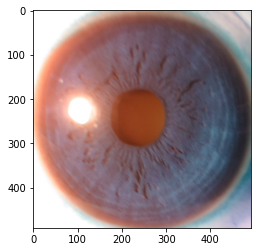

normal : 19.jpg : 111.0


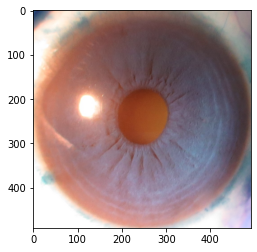

normal : 2.jpg : 72.0


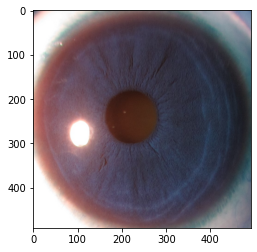

normal : 20.jpg : 75.0


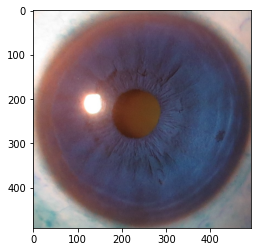

normal : 21.jpg : 87.0


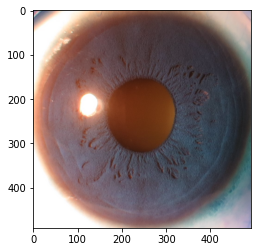

normal : 22.jpg : 154.0


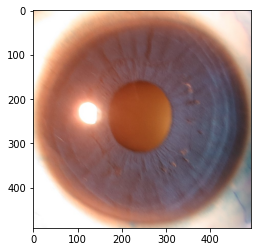

normal : 23.jpg : 83.0


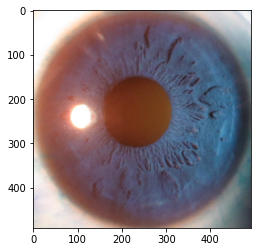

normal : 24.jpg : 87.0


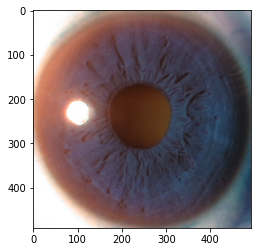

normal : 25.jpg : 72.0


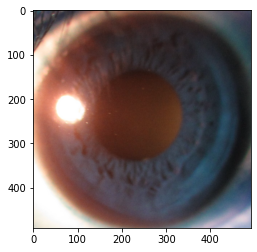

normal : 26.jpg : 145.0


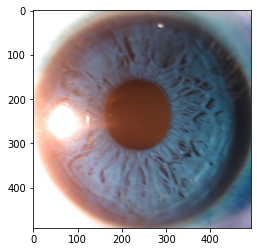

normal : 3.jpg : 143.0


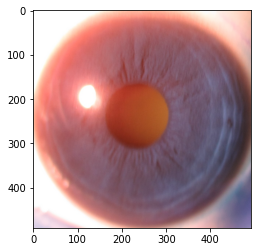

normal : 4.jpg : 80.0


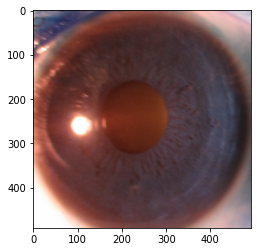

normal : 5.jpg : 130.0


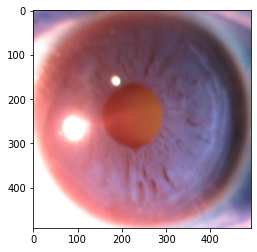

normal : 6.jpg : 81.0


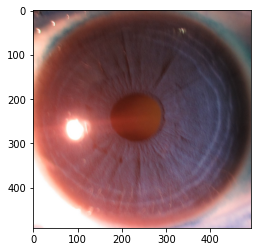

normal : 7.jpg : 120.0


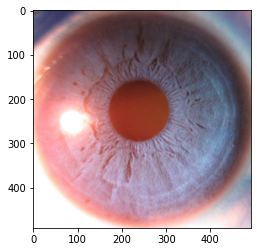

normal : 8.jpg : 57.0


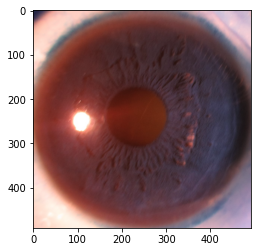

normal : 9.jpg : 99.0


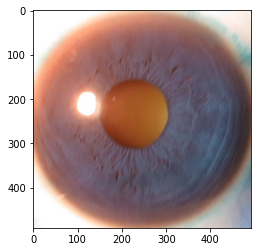

In [5]:
import os
import cv2
import numpy as np

#labels = ["tinggi", "sedang", "normal"]
labels = ["tinggi", "sedang", "normal"]
direktori = "./Dataset_old/test/"
list_img = {}
result = []

for label in labels :
    dummy_images = []
    for count, data in enumerate(os.listdir(direktori + label)) :
        img = cv2.imread(direktori + label + "/" + data)
        img = cv2.resize(img, (491, 491), interpolation = cv2.INTER_AREA)
        threshold = houghTransform(img)
        result.append(label + "," + str(threshold))
        print(label + " : " + data + " : " + str(threshold))
        plt.imshow(img)
        plt.show()
        dummy_images.append(data)
    list_img[label] = dummy_images

#print(result)
f = open("result.csv", "w+")
f.write("label,value\n")
for r in result :
    f.write(r + "\n")
f.close()